In [84]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd 
import random
import math
from scipy.stats import expon
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv
from pandas.plotting import autocorrelation_plot
import scipy.optimize as optim

#from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn')
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()

In [78]:
file_name = 'Covid19SN_datas.xlsx'
df_senegal = pd.read_excel(file_name, index_col=0)
df_senegal.shape
df_senegal = df_senegal.reset_index()
df_senegal['Date'] = pd.to_datetime(df_senegal['Date'])
df_senegal.tail()

,Country,lat,long,Date,Daily_case,Confirmed_cases,Imported_cases,Cum_Imported_cases,contacts,Cum_contacts,Communities_cases,Cum_communities_cases,Recovered,Cum_recored,Nb_tests,Cum_Nb_tests,Dead,Cum_Dead,evacuat_out,Cum_evacuat_out
51,Senegal,14.497450,-14.452450,2020-04-22,30,442,0,85,26,310,4,47,11,253,482,6251,1,6,0,1
52,Senegal,14.497451,-14.452451,2020-04-23,37,479,0,85,29,339,8,55,4,257,387,6638,0,6,0,1
53,Senegal,14.497452,-14.452452,2020-04-24,66,545,0,85,61,400,5,60,5,262,528,7166,1,7,0,1
54,Senegal,14.497453,-14.452453,2020-04-25,69,614,0,85,63,463,6,66,14,276,703,7869,0,7,0,1
55,Senegal,14.497454,-14.452454,2020-04-26,57,671,1,86,47,510,9,75,7,283,579,8448,2,9,0,1


In [79]:
def get_daily_var(ct,df):
    
    """
      This function takes the countries name and database in parameters.
      It returns a datframe with daily cases value and date as index
    """
    #Prepare country data
    ct_df = df[df['Country'] == ct]
    first_date = ct_df[ct_df['Confirmed_cases'] != 0]['Date'].values[0]
    confirmed = ct_df[ct_df['Date'] >= first_date]
    confirmed_cases = confirmed[['Date', 'Daily_case']].set_index('Date')
    
    
    return confirmed_cases

In [80]:
def get_pred_data (conf):
          
    """
      This function takes the daily dataframe and return it as arrays value
      for modelling purpose
    """
    #rearange dataframe values in array format
    cases_daily = np.array(conf).reshape(-1,1)
    cases_cum = np.array(conf.cumsum()).reshape(-1,1)
    days_since = np.arange(len(conf)).reshape(-1,1)
    
    return  cases_daily, cases_cum, days_since

In [81]:
def get_pred_date (n, conf):
    
    """
      This function generates n days for prediction
    """
    future_forcast = np.arange(len(conf) + n).reshape(-1,1)
    start_date = conf.index[0]
    future_forcast_dates = [(start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y') for i in range(len(future_forcast))] 
    
    return future_forcast,future_forcast_dates

In [82]:
cases_df = get_daily_var('Senegal',df_senegal)   
cases_daily, cases_cum, days_since = get_pred_data(cases_df)
#future_forcast,future_forcast_dates = get_pred_date(7, cases_df)

AttributeError: type object 'datetime.datetime' has no attribute 'timedelta'

In [85]:
n = 10
days_in_future = n
future_forcast = np.array([i for i in range(len(cases_daily)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-n]

start = '03/03/2020'
start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y'))

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

# Modele ARMA

Choose best parameters models ARIMA

In [62]:
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [66]:
import warnings
warnings.filterwarnings("ignore")
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(cases_daily, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=570.405
ARIMA(0, 0, 1) MSE=280.801
ARIMA(0, 1, 0) MSE=123.035
ARIMA(0, 1, 1) MSE=134.796
ARIMA(1, 0, 0) MSE=148.774
ARIMA(1, 1, 0) MSE=126.081
ARIMA(1, 1, 1) MSE=140.045
ARIMA(2, 0, 0) MSE=145.558
ARIMA(2, 1, 0) MSE=129.007
ARIMA(2, 1, 1) MSE=167.202
ARIMA(4, 0, 0) MSE=149.082
ARIMA(4, 1, 0) MSE=149.404
ARIMA(4, 1, 1) MSE=164.520
ARIMA(6, 1, 0) MSE=185.071
ARIMA(8, 1, 0) MSE=192.441
ARIMA(10, 1, 0) MSE=215.210
Best ARIMA(0, 1, 0) MSE=123.035


predicted=6.500488, expected=11.000000
predicted=8.979554, expected=7.000000
predicted=8.377567, expected=6.000000
predicted=7.564590, expected=15.000000
predicted=10.639923, expected=13.000000
predicted=11.786371, expected=2.000000
predicted=8.710111, expected=11.000000
predicted=9.711041, expected=8.000000
predicted=9.367470, expected=15.000000
predicted=11.328689, expected=21.000000
predicted=14.769615, expected=7.000000
predicted=12.522037, expected=8.000000
predicted=11.623039, expected=17.000000
predicted=13.207393, expected=10.000000
predicted=12.703135, expected=35.000000
predicted=15.444434, expected=30.000000
predicted=24.564430, expected=37.000000
predicted=32.563144, expected=66.000000
predicted=56.773881, expected=69.000000
predicted=68.174715, expected=57.000000
Test MSE: 134.796


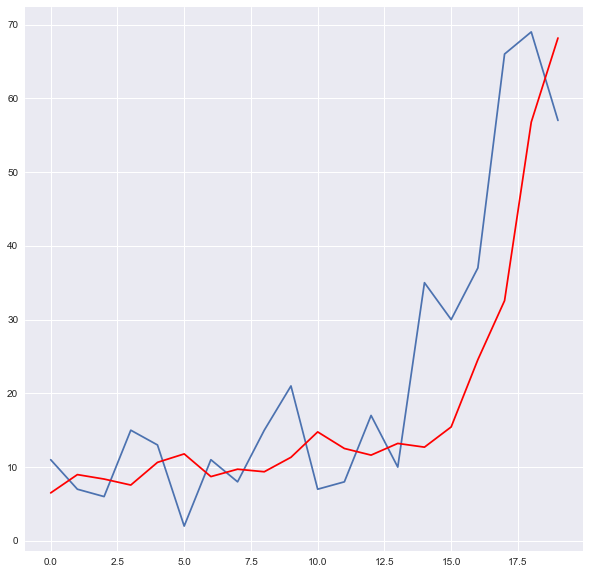

In [70]:
Xvalues = cases_daily
size = int(len(Xvalues) * 0.66)
train, test = Xvalues[0:size], Xvalues[size:len(Xvalues)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize=(10,10))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Autoregression (AR)

In [72]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# contrived dataset
data = cases_daily
size = int(len(data) * 0.66)
train, test = data[0:size], data[size:len(data)]
# fit model
AR_model = AR(data)
AR_model_fit = AR_model.fit()
# make prediction
yhat = AR_model_fit.predict(len(data), len(data))
print(yhat)

#model_fit.predict(1,1)

[75.79357451]


In [73]:
# Future predictions using Linear Regression 
print('Model AR future predictions:')
set(zip(future_forcast_dates[23:23+7], np.round(AR_model_fit.predict(len(data),len(data)+6)) ))

Model AR future predictions:


NameError: name 'future_forcast_dates' is not defined

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(future_forcast_dates[23:23+7], model_fit.predict(len(data),len(data)+6) )
plt.show()